In [1]:
import requests
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import re

In [2]:
from selenium import webdriver 


In [3]:
option = webdriver.ChromeOptions()
# set the window size to 1920x1080
option.add_argument("--window-size=150,1080")

In [4]:
path = 'C:\Program Files (x86)\chromedriver.exe'
driver = webdriver.Chrome(executable_path= path,options=option)
#driver.get('https://www.google.com/')

#### Using depth-first technique

In [5]:
# use selenium to get the html of the page
def get_html(url):
    driver.get(url)
    time.sleep(5)
    html = driver.page_source
    return html

# use beautiful soup to parse the html
def get_soup(html):
    soup = BeautifulSoup(html, 'html.parser')
    return soup

def get_number_of_pages(soup):
    # use exception handling to avoid errors
    try:
        number = soup.find('span', {'class': 'css-1a5jpu7'})
        number = number.text
        number = number.split('/')[-1]
        number = int(number)
    except:
        number = 1
    return number

# create a list of urls to scrape
def get_urls_with_page_numbers(soup,number,website):
    if number == 1:
        urls = [website]
    else:
        urls = []
        urls.append(website)
        for i in range(1, number):
            urls.append(website + '&start=' + str(i))
    return urls


In [6]:
# define a function to get the job details from the page
def get_job_details(soup):

    job_title = []
    job_url = []
    company_name = []
    company_location = []
    job_post_date = []
    job_duration = []
    job_experience_level = []
    job_experience_duration = []
    job_tags = []
    
    body = soup.find('body')
    parent = body.find('div', {'class': 'css-9i2afk'})
    parent = parent.findChildren(recursive=False)[1]
    main =  'https://wuzzuf.net'
    # find the children of the parent
    children = parent.findChildren(recursive=False)

    #print(children[0].prettify())
    # iterate through the children and get the job details

    for child in children:
        job_duration_node = []
        job_tags_node = []
        job_post = child.findChildren()[0]
        #print(job_post.prettify())
        job_head = job_post.findChild('div', {'class': 'css-laomuu'})
        job_body = job_post.findChild('div', {'class': 'css-y4udm8'})
        #print(job_head.prettify())
        # job_title inside the job_head
        try:
            job_title_node = job_head.findChild('h2', {'class': 'css-m604qf'})
            job_title_node = job_title_node.findChild('a')
            job_url_node = job_title_node.get('href')
            job_url_node = main + job_url_node
            job_title_node = job_title_node.text
        except:
            job_title_node = np.nan
            job_url_node = np.nan
        job_url.append(job_url_node)
        job_title.append(job_title_node)
        #print(job_title)

        # job_details inside the job_head
        try:
            job_details = job_head.findChild('div', {'class':'css-d7j1kk'})

            company_name_node = job_details.findChild('a').text
            company_location_node = job_details.findChild('span').text
            job_post_date_node = job_details.findChild('div').text
        except:
            company_name_node = np.nan
            company_location_node = np.nan
            job_post_date_node = np.nan

        company_name.append(company_name_node)
        company_location.append(company_location_node)
        job_post_date.append(job_post_date_node)

        #print(company_name)
        # job_description inside the job_body
        job_body_head = job_body.findChildren()[0]
        job_body_head = job_body_head.findChildren()

        try:
            for post in job_body_head:
                job_duration_node.append(post.text)
            job_duration_node = set(job_duration_node)

        except:
            job_duration_node = np.nan
        job_duration.append(job_duration_node)


        job_body_body = job_body.findChildren('div')[1]
        try:
            job_experience_level_node = job_body_body.findChild('a').text
            job_experience_duration_node = job_body_body.findChild('span').text
            job_tags_node = job_body_body.findChildren('a')[1:]
            job_tags_node = [tag.text for tag in job_tags_node]


        except:
            job_experience_level_node = np.nan
            job_experience_duration_node = np.nan
            job_tags_node = np.nan

        job_experience_level.append(job_experience_level_node)
        job_experience_duration.append(job_experience_duration_node)
        job_tags.append(job_tags_node)

    return job_title, job_url, company_name, company_location, job_post_date, job_duration, job_experience_level, job_experience_duration, job_tags


In [28]:
# loop over the job_url column and get the job requirements
def get_job_requirements_description(job_url):
    job_requirement_list = []
    job_description_list = []
    job_logo_list = []
    progress = 0
    len_urls = str(len(job_url))
    for url in job_url:
        html = get_html(url)
        soup = get_soup(html)
        #job_description.append(get_job_description(soup))
        job_requirement = []
        job_description = []
        try:
            job_requirement_node = soup.find('div', {'class':'css-1t5f0fr'})
            job_requirement_node = job_requirement_node.findChildren()
            for node in job_requirement_node:
                job_requirement.append(node.text)
        except:
            job_requirement = np.nan
        #print(job_description)
        job_requirement_list.append(job_requirement)

        try:
            job_description_node = soup.find('div', {'class':'css-1uobp1k'})
            job_description_node = job_description_node.findChildren()
            for node in job_description_node:
                job_description.append(node.text)
        except:
            job_description = np.nan
            
        job_description_list.append(job_description)

        try:
            job_logo_node = soup.find('img', {'class':'css-jb4x6y'})
            job_logo_node = job_logo_node.get('src')

        except:
            job_logo_node = np.nan
        job_logo_list.append(job_logo_node)

        progress += 1
        clear_output(wait=True)
        print('Progress: ' + str(progress) + '/' + len_urls)
        
    return job_requirement_list, job_description_list, job_logo_list
    

In [8]:
def get_page_urls(websites):
    urls = []
    for website in websites:
        html = get_html(website)
        soup = get_soup(html)
        number = get_number_of_pages(soup)
        print(number)
        urls.append(get_urls_with_page_numbers(soup,number,website))

    # flatten the list of lists
    urls = [url for sublist in urls for url in sublist]
    return urls


In [9]:
def search(search_key_words):
    websites = []
    main = 'https://wuzzuf.net'
    search = '/search/jobs/?a=hpb%7Cspbg&q='

    # create a list of websites to scrape using the main website and the jobs list
    for search_key_word in search_key_words:
        websites.append(main + search + search_key_word.split(' ')[0] + '%20' + search_key_word.split(' ')[1])
    return websites


In [10]:
# import clear_output to clear the output
from IPython.display import clear_output
def scraping(urls):
    job_title = []
    job_url = []
    company_name = []
    company_location = []
    job_post_date = []
    job_duration = []
    job_experience_level = []
    job_experience_duration = []
    job_tags = []

    progress = 0
    len_urls = str(len(urls))

    for url in urls:
        html = get_html(url)
        soup = get_soup(html)
        # wait for 10 seconds
        #time.sleep(10)
        job_title_page, job_url_page, company_name_page, company_location_page, job_post_date_page, job_duration_page, job_experience_level_page, job_experience_duration_page, job_tags_page = get_job_details(soup)
        
        # append the lists
        job_title.extend(job_title_page)
        job_url.extend(job_url_page)
        company_name.extend(company_name_page)
        company_location.extend(company_location_page)
        job_post_date.extend(job_post_date_page)
        job_duration.extend(job_duration_page)
        job_experience_level.extend(job_experience_level_page)
        job_experience_duration.extend(job_experience_duration_page)
        job_tags.extend(job_tags_page)
        
        # get the progress by calculating the number of pages scraped so far and the total number of pages
        progress = progress + 1
        clear_output(wait=True)
        print('Progress: ' + str(progress) + '/' + len_urls)
        print('Number of jobs scraped: ' + str(len(job_title)))



    # append the lists to the dataframe
    df = pd.DataFrame({'job_title': job_title,'job_url': job_url ,'company_name': company_name, 'company_location': company_location, 'job_post_date': job_post_date, 'job_duration': job_duration, 'job_experience_level': job_experience_level, 'job_experience_duration': job_experience_duration, 'job_tags': job_tags})
    return df
    

In [13]:
search_key_words = ['artificial intelligence','machine learning','data science','data analyst','data warehouse']
websites = search(search_key_words)

In [14]:
urls = get_page_urls(websites)
urls[:5]

1
3
41
13
6


['https://wuzzuf.net/search/jobs/?a=hpb%7Cspbg&q=artificial%20intelligence',
 'https://wuzzuf.net/search/jobs/?a=hpb%7Cspbg&q=machine%20learning',
 'https://wuzzuf.net/search/jobs/?a=hpb%7Cspbg&q=machine%20learning&start=1',
 'https://wuzzuf.net/search/jobs/?a=hpb%7Cspbg&q=machine%20learning&start=2',
 'https://wuzzuf.net/search/jobs/?a=hpb%7Cspbg&q=data%20science']

In [15]:
df = scraping(urls)

Progress: 64/64
Number of jobs scraped: 932


In [16]:
job_url = df['job_url'].tolist()
job_url[:5]

['https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Artificial-IntelligenceMachine-Learning-Lead-SURE-International-Technology-Cairo-Egypt?o=1&l=sp&t=sj&a=artificial intelligence|search-v3|hpb|spbg',
 'https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artificial-Intelligence-AI-Engineer-Riyadh-Saudi-Arabia?o=2&l=sp&t=sj&a=artificial intelligence|search-v3|hpb|spbg',
 'https://wuzzuf.net/jobs/p/ZRkuYvC25umo-Senior-Computer-Vision-Engineer-wobot-ai-New-Delhi-India?o=3&l=sp&t=sj&a=artificial intelligence|search-v3|hpb|spbg',
 'https://wuzzuf.net/jobs/p/r8foaAQzdmDJ-Product-Designer-Cow-Gifts-Cairo-Egypt?o=4&l=sp&t=sj&a=artificial intelligence|search-v3|hpb|spbg',
 'https://wuzzuf.net/jobs/p/xVOqL0uIwwBy-Professor-Lecturer-in-Computer-Science-MSA-October-University-Giza-Egypt?o=5&l=sp&t=sj&a=artificial intelligence|search-v3|hpb|spbg']

In [42]:
job_requirements, job_description,company_logo = get_job_requirements_description(job_url)

Progress: 932/932


In [43]:
job_requirements[0]

['Bachelor’s degree in Statistics, Computer Science, or in an Engineering or Sciences discipline or related degreeAt least 5 years experience in analytics, data science, ML EngineeringAt least 1-2 years of experience leading, mentoring, and developing either Machine Learning, Data Science, or Analytics practitioners.Experience with building and deploying a range of deep learning models into productionExperience with Cloud Services - Amazon Web Services (AWS)Highly proficient in ML and Deep learning algorithms with a hands-on project.Strong experience working with big data tools: Hadoop, Spark, Kafka, etc.Extensive Python experience required.Experience with Agile tools like Jira.Able to communicate technical issues with technical & non-technical stakeholders.Ability to quickly prototype ideas and solve complex problems by adapting creative approaches,',
 'Bachelor’s degree in Statistics, Computer Science, or in an Engineering or Sciences discipline or related degree',
 'At least 5 years

In [44]:
job_description[0]

['Lead, mentor, and advise the ML team members.Identify the most effective architectures and models to solve complex data problems.Research and implement appropriate ML algorithms and tools using deep learning and artificial neural networks.Designing AI/ML pipelines.Extend existing ML libraries and frameworks.The document, summarize and present findings to a group of peers and stakeholders across multiple projects.',
 'Lead, mentor, and advise the ML team members.',
 'Identify the most effective architectures and models to solve complex data problems.',
 'Research and implement appropriate ML algorithms and tools using deep learning and artificial neural networks.',
 'Designing AI/ML pipelines.',
 'Extend existing ML libraries and frameworks.',
 'The document, summarize and present findings to a group of peers and stakeholders across multiple projects.']

In [45]:
job_url[0]

'https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Artificial-IntelligenceMachine-Learning-Lead-SURE-International-Technology-Cairo-Egypt?o=1&l=sp&t=sj&a=artificial intelligence|search-v3|hpb|spbg'

In [46]:
company_logo[0]

'https://images.wuzzuf-data.net/files/company_logo/SURE-International-Technology-Egypt-21250-1516284267-sm.jpg'

In [47]:
# append the lists to the dataframe
df['job_requirements'] = job_requirements
df['job_description'] = job_description
df['company_logo'] = company_logo

In [48]:
df.head()

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,job_description,company_logo
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology -,"Cairo, Egypt",5 days ago,{Full Time},Manager,· 5+ Yrs of Exp,"[ · IT/Software Development, · Operations/Man...","[Bachelor’s degree in Statistics, Computer Sci...","[Lead, mentor, and advise the ML team members....",https://images.wuzzuf-data.net/files/company_l...
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential -,"Riyadh, Saudi Arabia",25 days ago,{Full Time},Experienced,· 2 - 4 Yrs of Exp,"[ · IT/Software Development, · Analyst/Resear...",[BA/BS degree in computer science or related d...,[Develops required machine learning models or ...,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
2,Senior Computer Vision Engineer,https://wuzzuf.net/jobs/p/ZRkuYvC25umo-Senior-...,wobot.ai -,"New Delhi, India",2 days ago,"{Full Time, Work From Home}",Senior Management,· 3 - 6 Yrs of Exp,"[ · IT/Software Development, · Engineering - ...","[Requirements:, Requirements:, Proficient with...","[Description:, Description:, This is a senior ...",https://images.wuzzuf-data.net/files/company_l...
3,Product Designer,https://wuzzuf.net/jobs/p/r8foaAQzdmDJ-Product...,Cow Gifts -,"New Cairo, Cairo, Egypt",5 days ago,{Full Time},Experienced,· 2 - 5 Yrs of Exp,[ · Engineering - Construction/Civil/Architect...,"[A Bachelors Degree in either Interior design,...",[Identify opportunities for new products.Analy...,https://images.wuzzuf-data.net/files/company_l...
4,Professor / Lecturer in Computer Science,https://wuzzuf.net/jobs/p/xVOqL0uIwwBy-Profess...,(MSA) October University -,"6th of October, Giza, Egypt",24 days ago,{Full Time},Experienced,· 5+ Yrs of Exp,"[ · IT/Software Development, · Engineering - ...","[PhD in Computer Science, Software Engineering...",[October University for Modern Sciences and Ar...,https://images.wuzzuf-data.net/files/company_l...


In [22]:
# get the number of duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   job_title                740 non-null    object
 1   company_name             740 non-null    object
 2   company_location         740 non-null    object
 3   job_post_date            740 non-null    object
 4   job_duration             740 non-null    object
 5   job_experience_level     738 non-null    object
 6   job_experience_duration  738 non-null    object
 7   job_tags                 738 non-null    object
dtypes: object(8)
memory usage: 46.4+ KB


In [50]:
df.to_csv('wuzzuf_before_cleaning.csv', index=False)

#### Data cleaning

In [51]:
# read the csv file
df = pd.read_csv('wuzzuf_before_cleaning.csv')
df_copy = df.copy()
df_copy.head(2)

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,job_description,company_logo
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology -,"Cairo, Egypt",5 days ago,{'Full Time'},Manager,· 5+ Yrs of Exp,"[' · IT/Software Development', ' · Operations/...","['Bachelor’s degree in Statistics, Computer Sc...","['Lead, mentor, and advise the ML team members...",https://images.wuzzuf-data.net/files/company_l...
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential -,"Riyadh, Saudi Arabia",25 days ago,{'Full Time'},Experienced,· 2 - 4 Yrs of Exp,"[' · IT/Software Development', ' · Analyst/Res...",['BA/BS degree in computer science or related ...,['Develops required machine learning models or...,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."


In [52]:
# data cleaning

# remove the last character from the job_company_name column
df_copy['company_name'] = df['company_name'].str[:-2]
df_copy['company_name'][0]

'SURE International Technology'

In [53]:
df['company_location'].str.split(', ')[0]

['Cairo', 'Egypt ']

In [54]:
# create a new column for the company_location 
len_company_location = len(df['company_location'].str.split(', ')[0])
len_company_location

2

In [55]:
locations = df['company_location']
town = []
city = []
country = []

for location in locations:
    len_company_location = len(location.split(', '))
    #print(len_company_location)
    if len_company_location == 3:
        town.append(location.split(', ')[0])
        city.append(location.split(', ')[1])
        country.append(location.split(', ')[2])

    elif len_company_location == 2:
        town.append(np.nan)
        city.append(location.split(', ')[0])
        country.append(location.split(', ')[1])

    else:
        town.append(np.nan)
        city.append(np.nan)
        country.append(location.split(', ')[0])

len(town), len(city), len(country)

(932, 932, 932)

In [56]:
df_copy['town'] = town
df_copy['city'] = city
df_copy['country'] = country

df_copy.head(2)

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,job_description,company_logo,town,city,country
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology,"Cairo, Egypt",5 days ago,{'Full Time'},Manager,· 5+ Yrs of Exp,"[' · IT/Software Development', ' · Operations/...","['Bachelor’s degree in Statistics, Computer Sc...","['Lead, mentor, and advise the ML team members...",https://images.wuzzuf-data.net/files/company_l...,NaN,Cairo,Egypt
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential,"Riyadh, Saudi Arabia",25 days ago,{'Full Time'},Experienced,· 2 - 4 Yrs of Exp,"[' · IT/Software Development', ' · Analyst/Res...",['BA/BS degree in computer science or related ...,['Develops required machine learning models or...,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,Riyadh,Saudi Arabia


In [57]:
# clean the job_post_date column
# if there is a day * 1
# if there is a week * 7
# if there is a month * 30
# if there is a year * 365

date_list = df_copy['job_post_date']
days = []
months = []
hours = []
for date in date_list:
    try:
        if 'day' in date:
            days.append(int(date.split(' ')[0]))
            months.append(np.nan)
            hours.append(np.nan)
        elif 'month' in date:
            days.append(np.nan)
            months.append(int(date.split(' ')[0]))
            hours.append(np.nan)
        elif 'hours' in date:
            days.append(np.nan)
            months.append(np.nan)
            hours.append(int(date.split(' ')[0]))
    except:
        print('1')
        days.append(np.nan)
        months.append(np.nan)
        hours.append(np.nan)

len(days), len(months), len(hours)

(932, 932, 932)

In [58]:

df_copy['post_date_days'] = days
df_copy['post_date_months'] = months
df_copy['post_date_hours'] = hours

df_copy.head(2)

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,job_description,company_logo,town,city,country,post_date_days,post_date_months,post_date_hours
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology,"Cairo, Egypt",5 days ago,{'Full Time'},Manager,· 5+ Yrs of Exp,"[' · IT/Software Development', ' · Operations/...","['Bachelor’s degree in Statistics, Computer Sc...","['Lead, mentor, and advise the ML team members...",https://images.wuzzuf-data.net/files/company_l...,NaN,Cairo,Egypt,5.0,NaN,NaN
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential,"Riyadh, Saudi Arabia",25 days ago,{'Full Time'},Experienced,· 2 - 4 Yrs of Exp,"[' · IT/Software Development', ' · Analyst/Res...",['BA/BS degree in computer science or related ...,['Develops required machine learning models or...,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,Riyadh,Saudi Arabia,25.0,NaN,NaN


In [59]:
# clean the job_duration column
full_time = []
part_time = []
freelance = []
internship = []
temporary = []
project = []



In [60]:
job_duration_list = df_copy['job_duration']
job_duration_list

0                        {'Full Time'}
1                        {'Full Time'}
2      {'Full Time', 'Work From Home'}
3                        {'Full Time'}
4                        {'Full Time'}
                    ...               
927                      {'Full Time'}
928                      {'Full Time'}
929                      {'Full Time'}
930                      {'Full Time'}
931                      {'Full Time'}
Name: job_duration, Length: 932, dtype: object

In [61]:
for job_duration in job_duration_list:
    if 'Full Time' in job_duration:
        full_time.append(1)
    else:
        full_time.append(0)
    if 'Part Time' in job_duration:
        part_time.append(1)
    else:
        part_time.append(0)
    if 'Freelance' in job_duration:
        freelance.append(1)
    else:
        freelance.append(0)
    if 'Internship' in job_duration:
        internship.append(1)
    else:
        internship.append(0)
    if 'Project' in job_duration:
        project.append(1)
    else:
        project.append(0)

len(full_time), len(part_time), len(freelance), len(internship), len(temporary), len(project)

(932, 932, 932, 932, 0, 932)

In [62]:
df_copy['full_time'] = full_time
df_copy['part_time'] = part_time
df_copy['freelance'] = freelance
df_copy['internship'] = internship
df_copy['project'] = project


In [63]:
df_copy.head(2)

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,...,city,country,post_date_days,post_date_months,post_date_hours,full_time,part_time,freelance,internship,project
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology,"Cairo, Egypt",5 days ago,{'Full Time'},Manager,· 5+ Yrs of Exp,"[' · IT/Software Development', ' · Operations/...","['Bachelor’s degree in Statistics, Computer Sc...",...,Cairo,Egypt,5.0,NaN,NaN,1,0,0,0,0
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential,"Riyadh, Saudi Arabia",25 days ago,{'Full Time'},Experienced,· 2 - 4 Yrs of Exp,"[' · IT/Software Development', ' · Analyst/Res...",['BA/BS degree in computer science or related ...,...,Riyadh,Saudi Arabia,25.0,NaN,NaN,1,0,0,0,0


In [64]:
# get the job_experience_duration column
df_copy['job_experience_duration'].unique()


array(['· 5+ Yrs of Exp', '· 2 - 4 Yrs of Exp', '· 3 - 6 Yrs of Exp',
       '· 2 - 5 Yrs of Exp', '· 4+ Yrs of Exp', '· 6+ Yrs of Exp',
       '· 3 - 5 Yrs of Exp', '· 1+ Yrs of Exp', '· 3 - 7 Yrs of Exp',
       '· 1 - 4 Yrs of Exp', '· 0 - 5 Yrs of Exp', '· 1 - 3 Yrs of Exp',
       '· 1 - 5 Yrs of Exp', '· 2+ Yrs of Exp', '· 3+ Yrs of Exp',
       '· 7 - 10 Yrs of Exp', '· 6 - 20 Yrs of Exp', '· 4 - 6 Yrs of Exp',
       '· 0 - 3 Yrs of Exp', '· 5 - 8 Yrs of Exp', '· 5 - 10 Yrs of Exp',
       '· 0 - 1 Yrs of Exp', '· 0 - 2 Yrs of Exp', '· 4 - 9 Yrs of Exp',
       '· 5 - 12 Yrs of Exp', '· 3 - 4 Yrs of Exp', '· 10+ Yrs of Exp',
       '· 5 - 9 Yrs of Exp', '· 3 - 18 Yrs of Exp', '· 2 - 6 Yrs of Exp',
       '· 5 - 7 Yrs of Exp', '· 5 - 5 Yrs of Exp', '· 8+ Yrs of Exp',
       '· 6 - 10 Yrs of Exp', '· 2 - 3 Yrs of Exp', '· 5 - 15 Yrs of Exp',
       '· 2 - 10 Yrs of Exp', '· 1 - 2 Yrs of Exp',
       '· 15 - 20 Yrs of Exp', '· 4 - 10 Yrs of Exp',
       '· 3 - 8 Yrs of Exp', '· 7+

In [65]:
# create a new column for the minimum experience
min_experience = df_copy['job_experience_duration']
# remove the first two characters from the job_experience_duration column
experience_list = []
for experience in min_experience:
    try:
        experience = experience[2:]
        experience = experience.split(' ')[0]
        # remove the + sign from the experience
        experience = experience.replace('+', '')
        experience_list.append(int(experience))
    except:
        experience_list.append(np.nan)

len(experience_list)



932

In [66]:
experience_list[:5]

[5, 2, 3, 2, 5]

In [67]:
df_copy['min_experience'] = experience_list
df_copy.head(2)

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,...,country,post_date_days,post_date_months,post_date_hours,full_time,part_time,freelance,internship,project,min_experience
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology,"Cairo, Egypt",5 days ago,{'Full Time'},Manager,· 5+ Yrs of Exp,"[' · IT/Software Development', ' · Operations/...","['Bachelor’s degree in Statistics, Computer Sc...",...,Egypt,5.0,NaN,NaN,1,0,0,0,0,5.0
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential,"Riyadh, Saudi Arabia",25 days ago,{'Full Time'},Experienced,· 2 - 4 Yrs of Exp,"[' · IT/Software Development', ' · Analyst/Res...",['BA/BS degree in computer science or related ...,...,Saudi Arabia,25.0,NaN,NaN,1,0,0,0,0,2.0


In [68]:
df_copy['min_experience'].value_counts()

3.0     239
2.0     183
5.0     146
1.0     121
4.0      86
0.0      54
7.0      36
6.0      21
8.0      16
10.0     15
12.0      6
15.0      3
9.0       2
20.0      1
Name: min_experience, dtype: int64

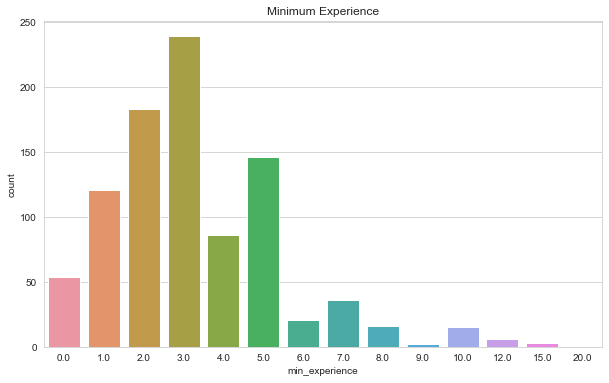

In [69]:
# plot the min_experience column
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='min_experience', data=df_copy)
plt.title('Minimum Experience')
plt.show()


In [70]:
df['job_experience_level'].value_counts()

Experienced          655
Entry Level          167
Manager               99
Senior Management     10
Name: job_experience_level, dtype: int64

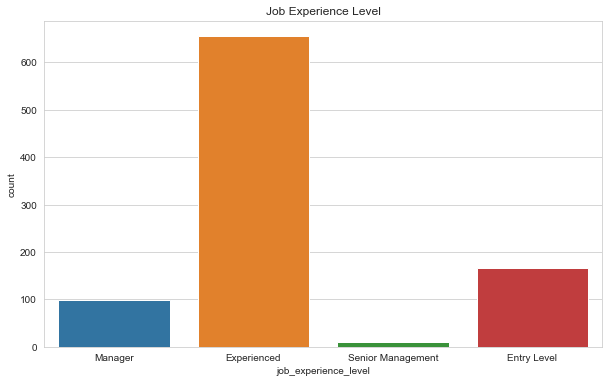

In [71]:
# plot the job_experience_level column
plt.figure(figsize=(10, 6))
sns.countplot(x='job_experience_level', data=df_copy)
plt.title('Job Experience Level')
plt.show()


In [72]:
from unittest import skip


job_tags = df_copy['job_tags']

job_tags_list = []
for job_tag in job_tags:
    skip

job_tag.split(',')

# remove all the unnatural characters from the job_tag string using regex
import re
job_tags = df_copy['job_tags']
job_tags_list = []
for job_tag in job_tags:
    try:
        job_tag = re.sub(r'[^\w\s]','', job_tag)
        # remove spaces from the job_tag string
        job_tag = job_tag.split('  ')
        # remove the first item from the list
        job_tag = job_tag[1:]
        job_tags_list.append(job_tag)
    except:
        job_tags_list.append(np.nan)

len(job_tags_list)


932

In [73]:
job_tags_list[1]

['ITSoftware Development',
 ' AnalystResearch',
 ' Engineering',
 'TelecomTechnology Artificial Intelligence',
 ' Computer Science',
 ' English',
 ' Information Technology IT',
 ' Software Engineering']

In [74]:
# replace the job_tags column with the job_tags_list
df_copy['job_tags'] = job_tags_list
df_copy.head(2)

,job_title,job_url,company_name,company_location,job_post_date,job_duration,job_experience_level,job_experience_duration,job_tags,job_requirements,...,country,post_date_days,post_date_months,post_date_hours,full_time,part_time,freelance,internship,project,min_experience
0,AI/ML (Artificial Intelligence/Machine Learnin...,https://wuzzuf.net/jobs/p/O9CVoliDvZQz-AIML-Ar...,SURE International Technology,"Cairo, Egypt",5 days ago,{'Full Time'},Manager,· 5+ Yrs of Exp,"[ITSoftware Development, OperationsManagement...","['Bachelor’s degree in Statistics, Computer Sc...",...,Egypt,5.0,NaN,NaN,1,0,0,0,0,5.0
1,Artificial Intelligence (AI) Engineer,https://wuzzuf.net/jobs/p/DH9EDOqivogn-Artific...,Confidential,"Riyadh, Saudi Arabia",25 days ago,{'Full Time'},Experienced,· 2 - 4 Yrs of Exp,"[ITSoftware Development, AnalystResearch, En...",['BA/BS degree in computer science or related ...,...,Saudi Arabia,25.0,NaN,NaN,1,0,0,0,0,2.0


In [75]:
df_copy['job_tags'].iloc[0]    

['ITSoftware Development',
 ' OperationsManagement',
 ' Engineering',
 'TelecomTechnology',
 ' Computer Science',
 ' Python Artificial Intelligence',
 ' AI',
 ' Machine Learning',
 ' Engineering',
 ' Azure']

In [76]:
# drop the columns that have been cleaned
df_copy.drop(['company_location', 'job_post_date', 'job_duration', 'job_experience_duration'], axis=1, inplace=True)

In [ ]:
# save the cleaned dataframe to a csv file
df_copy.to_csv('cleaned_wuzzuf_data.csv', index=False)